In [2]:
import xlrd
import os
import numpy as np
import pandas as pd
import numpy as np

def write_all():
    workbook = xlrd.open_workbook("Closed End Fixed Income.xlsx")
    names = workbook.sheet_names()
    for x in range(0,workbook.nsheets):
        sheet = workbook.sheet_by_index(x)
        df = pd.DataFrame([sheet.row_values(x) for x in range(1, sheet.nrows)])
        df.columns = df.iloc[0]
        df = df[1:]
        name = names[x]
        if name not in ["HYG Index", "JNK Index"]:
            df.to_csv("funds_fixed_income/"+name.upper()+".csv")


In [3]:
def create_hf():   
    hf = pd.DataFrame({})
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    for x in my_dir:
        df = pd.read_csv("./funds_fixed_income/"+x)
        name = x.split(".csv")[0]
        cf = df["ID.WEIGHTS"].to_frame(name)
        #.iloc[:,-1]
        cf.index = df["ID"].replace(np.nan, "N/A")
        cf = cf.dropna(axis=0)
        na = cf[cf.index=="N/A"].astype('float').sum(axis=0)
        na += cf.iloc[cf.index.str[:4]=="#N/A"].sum(axis=0)
        cf = cf[(cf.index != "N/A") & (cf.index.str[:4]!="#N/A")]
        cf.loc["N/A"] = na
        cf = cf.groupby(level=0).sum()
        hf = hf.merge(cf, how='outer', left_index=True, right_index=True)


    hf = hf.fillna(0)
    hf = hf.astype('float')
    hf = hf.div(hf.sum(), axis=1)*100
    return hf
hf = create_hf()


In [4]:
def create_index():
    tf = pd.read_csv("./jnk_index.csv")
    sf = tf[["ID", "ID.WEIGHTS", "Unnamed: 11"]]
    sf.columns = ["Symbol","Weight", "Ticker"]
    return sf


In [5]:
def create_discount_df():
    global hf
    funds = hf.columns
    df = pd.read_csv("Discount.csv", index_col=0)
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)].iloc[:,:4]
    df = df.apply(lambda x: [x["Discount"].strip("%"),x["52W Discount"].strip("%"), x["Effective"].strip("%"), x["Distribution Rate"].strip("%")], axis=1, result_type='expand')
    df = df.replace("--",0)
    df.columns = ["Discount", "52W Discount", "Effective","Distribution"]
    df = df.astype('float')
    df["Discount_Weights"] = (((df["Discount"]+ (df["Discount"] - df["52W Discount"]))+100)/100)
    discount_df = df.reindex([x.upper() for x in hf.columns])
    return discount_df


In [6]:


def change_down(weights, find, no_change_nums):
    k = [x + (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]-.01)
    for x in no_change_nums:
        k[x] = weights[x]
    return k


def change_up(weights, find, no_change_nums):
    l = weights
    k = [x - (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]+.01)
    for x in no_change_nums:
        k[x] = weights[x]
    negs = abs(sum(list(filter(lambda x: max(x,0)==0, k))))
    zeros = list(filter(lambda x: max(k[x],0)==0, range(len(k))))
    for x in zeros:
        k[x] = 0
    zeros.append(find)
    zeros = zeros + no_change_nums
    not_zeros = list(filter(lambda x: x not in zeros, range(len(k))))
    for x in not_zeros:
        k[x] = k[x] - (negs/len(not_zeros))
    if negs != 0 and not_zeros == []:
        return False
    return k

def find(weights):
    global hf
    global sf
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    w = [max(x,0) for x in weights]
    val = sum(discount_df['Discount_Weights'] * w)
    [max(x,0) for x in weights]
    close_val = (abs(sum(filter(lambda x: x < 0, df["Weight"]-df["ours"])))+100)
    return close_val * val

def best(type, weights, ideal, ideal_weights):
    if weights == False:
        return ideal_weights
    if list(filter(lambda x: x < 0, weights)) != list():
        return ideal_weights
    global no_change_nums
    global find_num
    num = find(weights)
    if num < ideal:
        if type == "up":
            if weights[find_num] + .01 > 0:
                return best("up",  change_up(weights, find_num, no_change_nums), num, weights)
            else:
                return weights
        if type == "down":
            if weights[find_num] - .01 > 0:
                return best("down", change_down(weights, find_num, no_change_nums), num, weights)
            else: 
                return weights
    else:
        return ideal_weights
    
    
def go_through(weights):
    global no_change_num
    global find_num
    num = find(weights)
    dw = change_down(weights, find_num, no_change_nums)
    uw = change_up(weights, find_num, no_change_nums)
    if uw == False and dw == False:
        return weights
    elif uw == False:
        return best("down", dw,num, weights)
    elif dw == False:
        return (best("up", uw,num, weights))
    up = find(uw)
    down = find(dw)
    if up < down and up < num:
        return (best("up", uw,num, weights))
        
    elif down < num:
        return best("down", dw,num, weights)
    else:
        return weights
    
        




In [7]:
def do(way):
    global find_num
    global no_change_nums
    weights = [1/len(hf.columns) for x in range(len(hf.columns))]
    n = 0
    for x in way:
        find_num = x[0]
        no_change_nums = x[1]
        weights = go_through(weights)
        n+=1
    return weights

In [8]:
def path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y+1)
    


def path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y-1)

def weird_path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y-1)
    
def weird_path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y+1)

def way1(): 
    global z
    z = len(hf.columns)-1
    return path(0) + weird_path2(z)
    
def way2():
    global z
    z = len(hf.columns)-1
    return path(0) + path2(z)

def way3():
    global z
    z = len(hf.columns)-1
    return path2(z) + path(0)

def way4(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + weird_path(0)

def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way6(): 
    global z
    z = len(hf.columns)-1
    return path(0) + [7,[]] + path(0)
def way7(): 
    global z
    z = len(hf.columns)-1
    return path2(z)
def way8(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + [0,[]] + path2(z)
paths = [way1,way2,way3,way4]


In [9]:
def create_assets(weights):
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    tf = df[df['Weight']!=0]
    not_in = df[df['Weight']==0]["ours"].sum()
    tf = tf.rename(columns={"Weight":"Index"})
    tf = tf.sort_values(by=['ours'], ascending=False)
    i = pd.DataFrame([[not_in, 0]], ["notINs&p500"], columns=["ours","Index"])
    tf = tf.append(i)
    return tf

def how_much():
    global tf
    tf["more"] = tf["Index"] -tf["ours"]
    amount_more = abs(tf[tf["more"]<0]["more"]).sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    amount_sp500 = (100/(abs(tf[tf["more"]<0]["more"]).sum()+100))
    amount_buy = tf[tf["more"]>0]["more"].sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    return amount_sp500

def avg_discount():
    df = discount_df.reindex(hf.columns,axis=0)
    df["Weights"] = weights
    avg_discount = (df["Discount"]*df["Weights"]).sum()*amount_sp500
    return avg_discount

def avg_effective():
    df2 = discount_df.reindex(hf.columns,axis=0)
    df2["Weights"] = weights
    avg_discount = (df2["Effective"]*df2["Weights"]).sum()*amount_sp500
    return avg_discount

def avg_distribution():
    avg_discount = (discount_df["Distribution"]*weights).sum()
    return avg_discount

In [11]:
how_much_dis = [100, 0, -1, -2, -3,-4,-5,-6,-7,-8,-9,-10]
final = pd.DataFrame(columns=["Weights"])
dicty = []
path_num = 0
hf_orig = create_hf()
sf_orig = create_index()
hf = hf_orig
discount_df_orig = create_discount_df()


global discount_df
global weights

for way in paths:
    path_num += 1
    hf = hf_orig
    sf = sf_orig
    discount_df = discount_df_orig
    print(len(discount_df))
    print("NEXT")
    while True:
        if len(discount_df) == 20:
            break
        
        weights = do(way())

        weights = [round(x,5) for x in weights]
        weights_not_zero = list(filter(lambda x: x > 0,weights))
        if len(weights_not_zero) <= 2:
            continue
        tf = create_assets(weights)
        
        amount_sp500 = how_much()
        print(amount_sp500)
        
        average_discount = avg_discount()
        average_effective = avg_effective()
        average_distribution = avg_distribution()
        print(average_discount)
        df = discount_df.reindex(hf.columns,axis=0)
        df["Weights"] = weights
        df["hmd"] = str(path_num)+ "," + str(len(discount_df))
        df.index = pd.MultiIndex.from_frame(df.reset_index()[["hmd","index"]])
        final = pd.concat([final, df[["Weights"]]])
        dicty.append({
            "which": (str(path_num), str(len(discount_df))),
            "x":amount_sp500*100,
            "y": average_discount,
            "effective": average_effective,
            "distribution": average_distribution
        })
        discount_df = discount_df.sort_values(by=["Discount"], ascending=False)
        discount_df = discount_df.iloc[1:]
        hf = hf[discount_df.index]
       

final.index = pd.MultiIndex.from_tuples(final.index)

39
NEXT
0.6361768894303482
-6.0468059866460795
0.6388283884658772
-4.0356315460409515
0.6305199002105969
-4.185479055124021
0.6324539941012377
-4.302683943638593
0.6338214654619387
-4.398226652944941
0.636159686739156
-4.412566380486622
0.6367684305034421
-4.4884602537085545
0.6367875963132069
-4.48971501350793
0.6368430985369101
-4.49344180150549
0.6243219341888204
-6.015725044712491
0.6272715984722855
-6.110102848260818
0.6257864623195329
-6.066229471631401
0.6277240240807606
-6.132954107528499
0.625577901108784
-6.089618263849695
0.6272781152501813
-6.189348960410167
0.6270612927545144
-6.182582927961802
0.6270350762278719
-6.221202875154872
0.6273201283218651
-6.194374933370276
0.6271659452892764
-6.191515986391867
39
NEXT
0.6398498019498979
-5.565292197852782
0.6441136877835534
-5.343370634766217
0.6347862618590553
-4.6517815855545495
0.6365204480094636
-4.7795282912700365
0.6299407848187697
-6.421500451338133
0.6333575336622332
-6.43812746484916
0.6323863876310836
-6.372212028997

In [18]:
final.to_csv("final.csv")
k = pd.read_csv("../flask/hy_fixed_income/dataframes/final.csv", index_col=[0,1])
k.head()

Weights
1,38 CIF   0.08632
     EHT   0.00956
     JCO   0.00984
     BGIO  0.00012
     JHB   0.00100

In [22]:
hey = list(dicty)
# and t["distribution"] > y["distribution"] and t["effective"] < y["effective"]
t = list(dicty)
for y in hey:
    if list(filter(lambda t: t["x"] > y["x"] and t["y"] < y["y"], hey)) != []:
        t.remove(y)

i = list(filter(lambda x: x["which"][0] != '4',t))

In [23]:
import json
with open('../flask/hy_fixed_income/dataframes/dicty.json', 'w') as outfile:
    json.dump(i, outfile)

In [ ]:
dicty

<IPython.core.display.Javascript object>


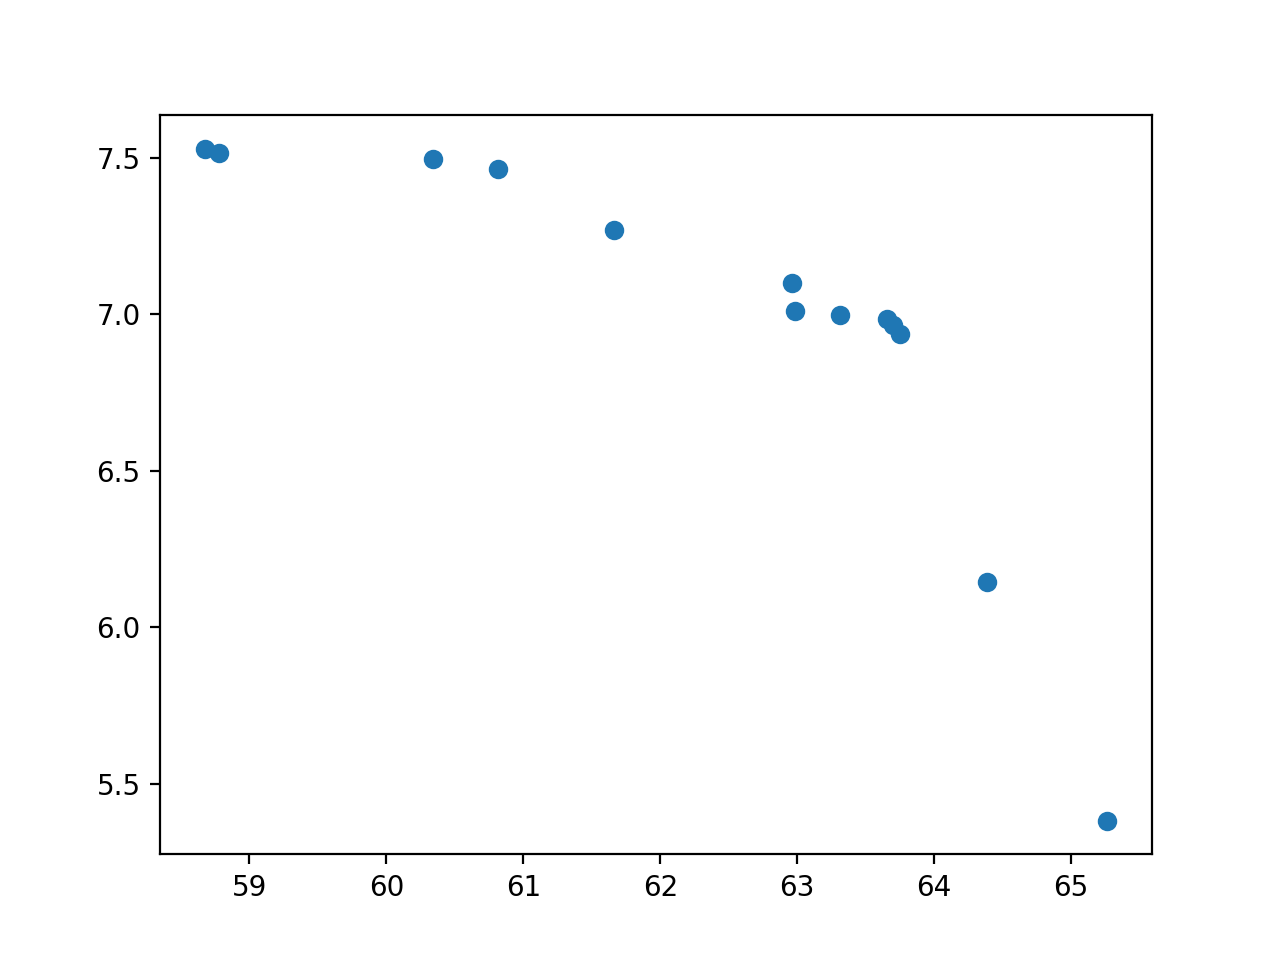

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot([x["x"] for x in t],[abs(x["y"]) for x in t],"o")
plt.show()

In [ ]:
def final_df():
    global hf
    funds = hf.columns
    df = pd.read_csv("Discount.csv", index_col=0)
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)].iloc[:,:4]
    df = df.apply(lambda x: [x["Discount"].strip("%"),x["52W Discount"].strip("%"), x["Effective"].strip("%"), x["Distribution Rate"].strip("%")], axis=1, result_type='expand')
    df = df.replace("--",0)
    df.columns = ["Discount", "52W Discount", "Effective","Distribution"]
    df = df.astype('float')
    
    return df


df = final_df()
i = final.iloc[final.index.get_level_values(0) == '1,38']

#list(filter(lambda x: x not in list(i.index.get_level_values(1)), df.index))
i.index = i.index.get_level_values(1)
df = i.merge(df, how="outer", right_index=True, left_index=True).fillna(0)

df = df.sort_values(by=["Weights"], ascending=False)
(df["Weights"]*df["Discount"]).sum()
